In [1]:
# Import Libraries
import numpy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

2023-01-05 10:54:26.794907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 10:54:28.708367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-05 10:54:28.708403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-05 10:54:28.872987: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-05 10:54:32.661670: W tensorflow/stream_executor/platform/de

In [2]:
# Define image size
image_size = (224, 224)

# import train data
train_ds = keras.utils.image_dataset_from_directory(
    directory='./data/train',
    seed = 1337,
    batch_size=64,
    image_size=image_size)

# import valid data
validation_ds = keras.utils.image_dataset_from_directory(
    directory='./data/valid',
    seed = 1337,
    batch_size=64,
    image_size=image_size)

# import test data
test_ds = keras.utils.image_dataset_from_directory(
    directory='./data/test',
    seed = 1337,
    batch_size=64,
    image_size=(image_size))

Found 2219 files belonging to 2 classes.


2023-01-05 10:54:43.146967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 10:54:43.147450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-05 10:54:43.148404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-05 10:54:43.149126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-05 10:54:43.150025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Found 741 files belonging to 2 classes.
Found 731 files belonging to 2 classes.


In [3]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

augmented_train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img, training = True), label))

In [4]:
# Build Model
def build_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = build_model(input_shape=image_size + (3,), num_classes=2)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 12  3584        ['rescaling[0][0]']              
                                8)                                                                
                                                                                              

In [5]:
# Train Model
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_ds,
)

Epoch 1/20
35/35 [==============================] - 472s 13s/step - loss: 0.5495 - accuracy: 0.7850 - val_loss: 0.6326 - val_accuracy: 0.8003
Epoch 2/20
35/35 [==============================] - 458s 13s/step - loss: 0.5153 - accuracy: 0.7981 - val_loss: 0.5837 - val_accuracy: 0.8003
Epoch 3/20
35/35 [==============================] - 460s 13s/step - loss: 0.5173 - accuracy: 0.7977 - val_loss: 0.5515 - val_accuracy: 0.8003
Epoch 4/20
35/35 [==============================] - 461s 13s/step - loss: 0.5129 - accuracy: 0.7963 - val_loss: 0.5303 - val_accuracy: 0.8003
Epoch 5/20
35/35 [==============================] - 472s 13s/step - loss: 0.5081 - accuracy: 0.7954 - val_loss: 0.5091 - val_accuracy: 0.8003
Epoch 6/20
35/35 [==============================] - 461s 13s/step - loss: 0.5181 - accuracy: 0.7909 - val_loss: 0.5020 - val_accuracy: 0.8003
Epoch 7/20
35/35 [==============================] - 460s 13s/step - loss: 0.4984 - accuracy: 0.7990 - val_loss: 0.5002 - val_accuracy: 0.8003
Epoch 

In [ ]:
#  Evaluate Model
score = model.evaluate(test_ds, batch_size=64)
print("test loss, test acc:", score)

12/12 [==============================] - 40s 3s/step - loss: 0.5028 - accuracy: 0.8044
test loss, test acc: [0.5027822256088257, 0.804377555847168]


In [ ]:
# Import test data
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('./data/test',
                                           target_size = (224,224),
                                           batch_size = 64,
                                           shuffle=False,
                                           class_mode ='binary')

test_steps_per_epoch = numpy.math.ceil(test_set.samples / test_set.batch_size)

# Collect predictions
predictions = model.predict_generator(test_set, steps=test_steps_per_epoch)
predictions = numpy.hstack(predictions)
predictions = [round(x) for x in predictions]


# collect true labels
true_classes = test_set.classes

# Collect Class labels
class_labels = list(test_set.class_indices.keys())

# Print Classification report
report = classification_report(true_classes, predictions, target_names=class_labels)
print(report) 

Found 731 images belonging to 2 classes.
              precision    recall  f1-score   support

         AFF       0.00      0.00      0.00       143
     CONTROL       0.80      1.00      0.89       588

    accuracy                           0.80       731
   macro avg       0.40      0.50      0.45       731
weighted avg       0.65      0.80      0.72       731



<AxesSubplot:>

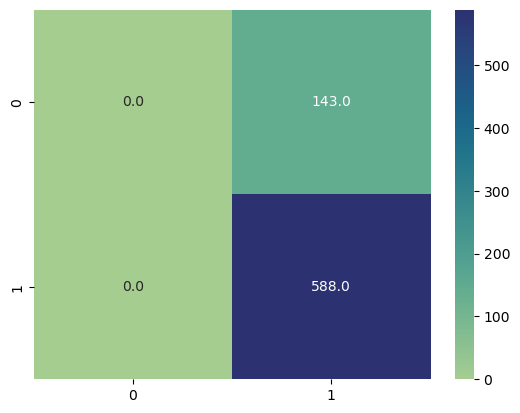

In [ ]:
# Print Confusion Matrix
cf_matrix = confusion_matrix(true_classes, predictions)
sns.heatmap(cf_matrix, annot=True, cmap="crest", fmt=".1f")